<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta 
import os
import re 
from functools import reduce
from collections import defaultdict, ChainMap, Counter

# Customer analysis

In [2]:
os.listdir()

['.config',
 'online_retail_II.xlsx',
 'test.csv',
 'scanner_data.csv',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sample_data']

In [3]:
df = pd.read_csv('scanner_data.csv')
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [6]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.columns = [a.lower() for a in df.columns]
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [8]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].to_numpy().astype('datetime64[W]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.sales_amount
df.rename(columns = {'customer_id':'id'}, inplace = True)
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount,week,month,rev
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-01-28,2016-02-01,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-01-28,2016-02-01,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-01-28,2016-02-01,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-01-28,2016-02-01,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-01-28,2016-02-01,6.88


In [11]:
df = df.groupby(['id','date','week','month'])['rev'].sum().reset_index()
df = df.sort_values(['id','date'], ascending = [1, 0])
df.head()

,id,date,week,month,rev
0,1,2016-01-22,2016-01-21,2016-01-01,16.29
2,2,2016-06-19,2016-06-16,2016-06-01,15.00
1,2,2016-03-24,2016-03-24,2016-03-01,7.77
3,3,2016-02-01,2016-01-28,2016-02-01,19.08
5,4,2016-11-07,2016-11-03,2016-11-01,6.69


In [27]:
info_m = df.groupby(['id','month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = ['id'], var_name = 'month', value_name = 'money')
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,1,16.29
1,2,7.77
2,3,19.08
3,4,0.00
4,5,132.03


In [28]:
info_f = df.groupby(['id','month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = ['id'], var_name = 'month', value_name = 'freq')
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,1,1.0
1,2,1.0
2,3,1.0
3,4,0.0
4,5,2.0


In [12]:
date_max = df['date'].max() + pd.offsets.MonthEnd()
date_max

Timestamp('2017-01-31 00:00:00')

In [38]:
info_r = df.groupby(['id']).agg({'date' : lambda x : (date_max - x.max())}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()


,id,recency
0,1,375
1,2,226
2,3,365
3,4,85
4,5,151


In [42]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info = info.assign(r = pd.qcut(info['recency'], 5, list('54321')),
                    f = pd.qcut(info['freq'].rank(method = 'first'), 5, list('12345')),
                    m = pd.qcut(info['money'].rank(method = 'first'), 5, list('12345'))
                    )
info['fm'] = info['f'].astype(str) + info['m'].astype(str)
info.head()

,id,recency,freq,money,r,f,m,fm
0,1,375,1.0,16.29,1,3,4,34
1,2,226,1.0,7.77,2,3,4,34
2,3,365,1.0,19.08,1,3,4,34
3,4,85,0.0,0.00,4,1,1,11
4,5,151,2.0,132.03,3,5,5,55


In [43]:
cnt = info.groupby(['fm'])['id'].count().reset_index().rename(columns = {'id':'cnt'})
cnt.head()

,fm,cnt
0,11,4525
1,22,4525
2,33,4385
3,34,91
4,35,49


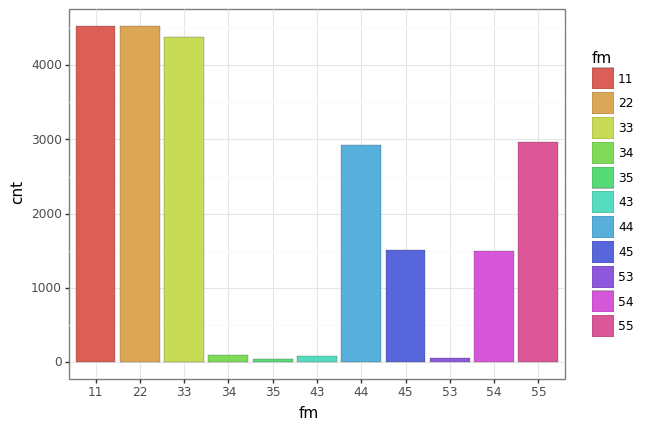

<ggplot: (8793804560573)>

In [45]:
(
    ggplot(cnt, aes('fm', 'cnt', fill = 'fm')) +
    gg.geom_col(color = '#333333', size = 0.1) +
    gg.theme_bw()
)

# iterator

In [47]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = {letters : [r, c] for r, rows in enumerate(mat) for c, letters in enumerate(rows)}
a

{'A': [0, 0],
 'B': [0, 1],
 'C': [0, 2],
 'D': [1, 0],
 'E': [1, 1],
 'F': [1, 2],
 'G': [2, 0],
 'H': [2, 1],
 'I': [2, 2]}

In [48]:
arr = np.empty([3,3], dtype = 'object')
for k, v in a.items() :
  arr[v[0],v[1]] = k 

arr

array([['A', 'B', 'C'],
       ['D', 'E', 'F'],
       ['G', 'H', 'I']], dtype=object)

In [49]:
def add_arthor_with_name(name) :
  def add_arthor(func) : 
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper 
  return add_arthor

def calc_time(func) :
  def wrapper(*args, **kwargs) :
    s = datetime.now()
    func(*args, **kwargs)
    e = datetime.now()
    print({e-s})
    return func(*args, **kwargs) 
  return wrapper

@calc_time
@add_arthor_with_name('kim')
def get_title(title) :
  return title

In [50]:
print(get_title('아무 것도 할 수 없잖아'))

{datetime.timedelta(microseconds=11)}
kim
아무 것도 할 수 없잖아
